# Lesson 1 - What's your pet

이 수업에서는 첫번째 이미지 분류 모델을 밑바닥부터 만들것이고, 세계 정상급 결과를 얻을 수 있는지 확인해 볼 것 이다.

앞으로 수업의 모든 노트북 파일은 아래 3줄의 코드를 기본으로 실행하고 시작한다. 

`%`으로 시작하는 코드는 파이썬 코드가아닌 주피터 노트북에서 사용할 수 있는 Magic code  이다.

autoreload 는 라이브러리들이 수정되었을때 자동으로 reload 되게 해주며, matplotlib 은 그래프가 노트북내에 표시되게 해준다.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

필요한 모든 패키지를 임포트하고 시작해보자. fastai는 다음과 같이 fastai.모듈명 으로 구조화되어 있다.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate


만약 작은(메모리가 작은) GPU를 사용하고 있다면, 이 노트북을 실행시키면서 OOM이 발생할 수 있다. 그렇다면 아래 bs = 16 코드를 실행시켜라

bs = batch size

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

이번에 사용할 데이터셋에 대해서 알아보자.  [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) 데이터셋을 사용할 것이다. 12종의 고양이와 25종의 강아지 이미지와 레이블링이 되어있는 데이터셋이다. 각 종마다 200장의 이미지가 있다. 우리가 만들 모델은 이 37(12+25)개의 카테고리를 분류하는 모델이 될 것이다. 2012년에는 최고 정확도가 59.21%밖에 미치지 못했지만, Deep learning을 사용하면 얼마나 높은 성능을 낼 수 있는지 알아보자. 

* 이 튜토리얼에서는 위와같은 아카데믹 데이터셋과 Kaggle의 데이터셋을 사용할 것이다. 

`untar_data` 함수를 사용해  URL을 넘겨주어 데이터를 다운받고 압축해제 시키자.

In [0]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [0]:
URLs.PETS # URLs.PETS 에 이번 튜토리얼에서 사용할 Pet 데이터셋의 주소가 저장되어 있다.

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [0]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations' # 파이썬에서는 Path 객체는 / 를 사용해서 path를 더해 갈 수 있다. 
path_img = path/'images'       # String 이였다면,  path_img = path + '/images' 와 같은 문법 

가장 처음으로 문제에 접근할 때에는  언제나  우리가 가진 데이터가 어떻게 생겼는지 확인해야 한다. 데이터를 살펴본다는 것(look at the data)은 데이터의 디렉터리가 어떻게 구조화 되어있고, 어떠한 레이블이 달려 있으며, 샘플 데이터는 어떻게 생겼는지 살펴보는 것이다.

이미지 분류 문제들의 주요한 차이점은 `레이블이 어떻게 저장되어 있는가` 이다. 이번에 사용할 데이터셋은 레이블이 해당 데이터의 *파일이름*으로 저장되어있다. 그러므로 모든 이미지 파일을 돌면서 파일 이름을 추출해 레이블로 저장해 두어야 한다. 

fastai에는 이러한 작업을 쉽게 도와주는 함수 `ImageDataBunch.from_name_re` 가 존재하므로 정규표현식을 사용해서 파일명에서 레이블을 추출할 수있다.[regular expression](https://docs.python.org/3.6/library/re.html).


In [0]:
fnames = get_image_files(path_img)
fnames[:5] # 앞의 5개의 파일의 이름만 출력해보자.

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_129.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_171.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_182.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_174.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_128.jpg')]

첫번째 이미지를 살펴보면, Abyssinian_129.jpg 과 같은 형태로 `레이블_번호.확장자` 형태로 파일이 구성됨을 알 수 있다.

그러므로 레이블만 추출하기 위해서 _숫자 이전까지의 문자열만 추출해보자.

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)
# size=224 와 같이 모든 이미지의 사이즈를 똑같이 결정해주어야 GPU가 병렬화 작업을 빠르게 할 수 있으므로 모든 이미지를 같은 사이즈로 맞춰야한다.
# normalize() 함수로 모든 이미지를 똑같은 체널(RGB)로 정규화 시켜준다. (히스토그램 이퀼라이저 같은 역할인지 모르겠다.)
# 모델이 학습을 더 수월하게 하도록 도와준다 정도로 이해.. (너무 밝거나 너무 어두운곳을 정규화 해주므로 너 제너럴한 이미지 생성..?)

fastai 의 모든 모델은 DataBunch 오브젝트를 사용한다.  DataBunch 는 2~3개의 데이터셋을 contain 할 수 있고,  batch size 만큼씩 불러와 사용할 수 있다.

DataBunch는 내부적으로 validation set을 자동으로 생성한다. 

(pytorch의 DataLoader와 같은 개념인듯)

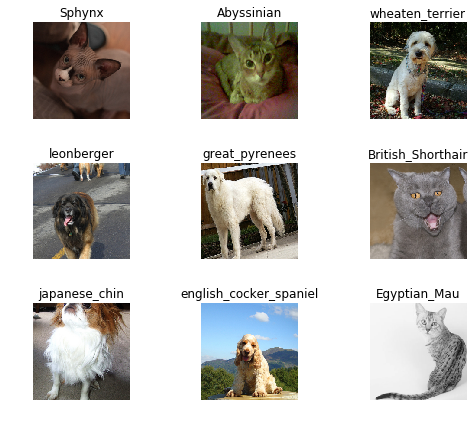

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes) # data.classes 로 레이블의 종류를 확인할 수 있다. (37 개의 클래스)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

우리의 모델을 학습시키기 위해 CNN 모델을 사용하고, FC layer 한층을 넣어 분류작업을 수행할 것이다. 
지금 당장은 우리가 만들 모델의 인풋과 아웃풋이 어떤 shape로 형성된는지 만 알고 넘어가도 좋다. 
인풋으로는 이미지를 전달받을 것이고, 아웃풋으로는 37개의 class에 대한 확률을 출력하게 될 것이다.

4 epoch (전체 데이터를 4번 반복 학습)을 진행할 것.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate) # fastai는 learner 클래스에 모델과 데이터 그리고 metric을 넣어 사용한다.

fastai 의 models.resnet34를 불러오면 이미 학습된 (pre-trained) resnet을 그대로 가져온다. (구조뿐만 아니라 파라메터도 가져옴)

resnet34는 기본적으로 1000개의 카테고리를 구분하는 이미지넷 모델이므로 우리가 가진 PET 데이터셋으로 Fine-Tuning을 진행해야 한다. 

전이학습(Transfer learning)은 다음 링크 참조 http://incredible.ai/artificial-intelligence/2017/05/13/Transfer-Learning/]


위와 같이 사전 학습된 모델을 가져오면 Convolution Layer 들은 모두 freeze(파라메터 변경 X) 되므로 학습되지 않는다.

다만 마지막에 이미지 분류를 위해 추가된 FC layer만 학습이 이뤼짐.

---


error_rate 를 메트릭으로 지정해주면, 자동으로 validation set 을 사용해 모델이 학습되는 동안 score를 출력해준다.

이때 validation set은 우리가 DataBunch를 사용해서 데이터를 꾸리면 자동으로 생성된다.

In [0]:
learn.model # 우리가 만든 learner에 resnet34 모델을 넣었다. 그러므로 아래는 resnet34의 구조를 살펴볼 수 있다.

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.fit_one_cycle(4) # fit 말고 fit_one_cycle이 좋다. (다음 강의에서 이유를 설명)

epoch,train_loss,valid_loss,error_rate,time
0,1.399652,0.345156,0.111637,01:47
1,0.561015,0.233345,0.070365,01:45
2,0.341529,0.207650,0.062246,01:47
3,0.256634,0.205607,0.069012,01:47


In [0]:
learn.save('stage-1') # 지금까지 학습한 모델을 저장해두자.

## Results

모델 학습으로 생성된 결과를 확인해보자.

첫번째로 모델이 가장 헷갈려하는 카테고리를 확인해보자. 모델의 예측(predict)가 합리적이였는지 아니였는지 확인해보자. 

더 나아가서 confusion matrix를 그려보자. 아래 결과를 보면 알 수 있듯이, distribution 이 매우 치우쳐(skewed) 있다.
이 뜻은 모델이 똑같은 실수(잘못된 예측)를 계속 반복하지만, 다른 카테고리에서는 거의 헷갈려하지 않는다는 의미이다. 

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

높은 Loss를 기록하는 경우는 모델이 확실하게(높은 Prob) 해당 데이터를 잘못 예측했을 때이다.

(A일 확률이 0.99라고 예측했지만, 실제로 A가 아닐때)

가장 높은 Loss를 기록한 9개의 이미지를 출력해보자.

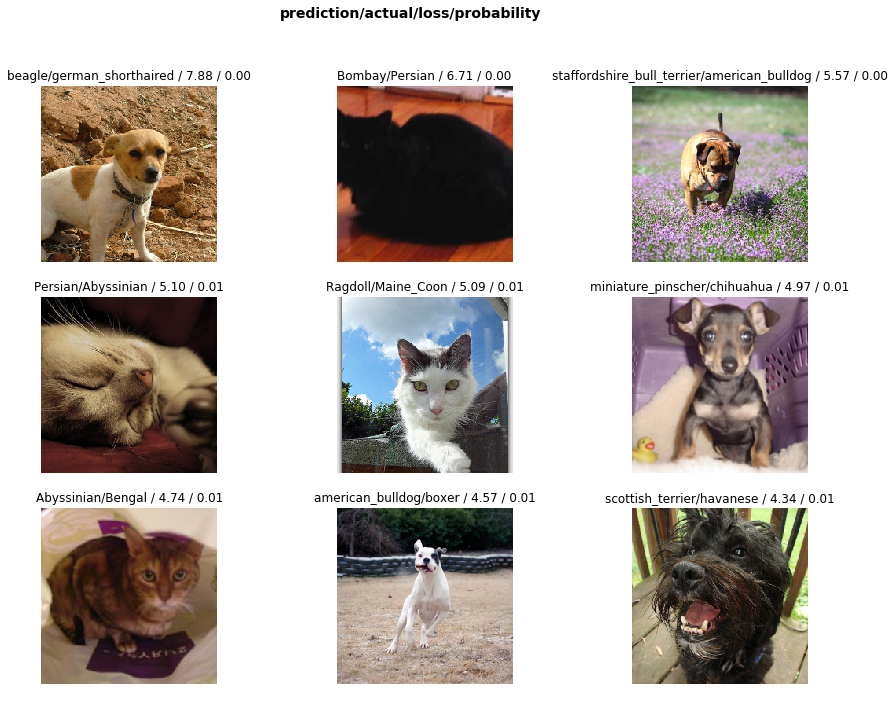

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses) # 해당 함수의 document를 열어 볼 수 있다.

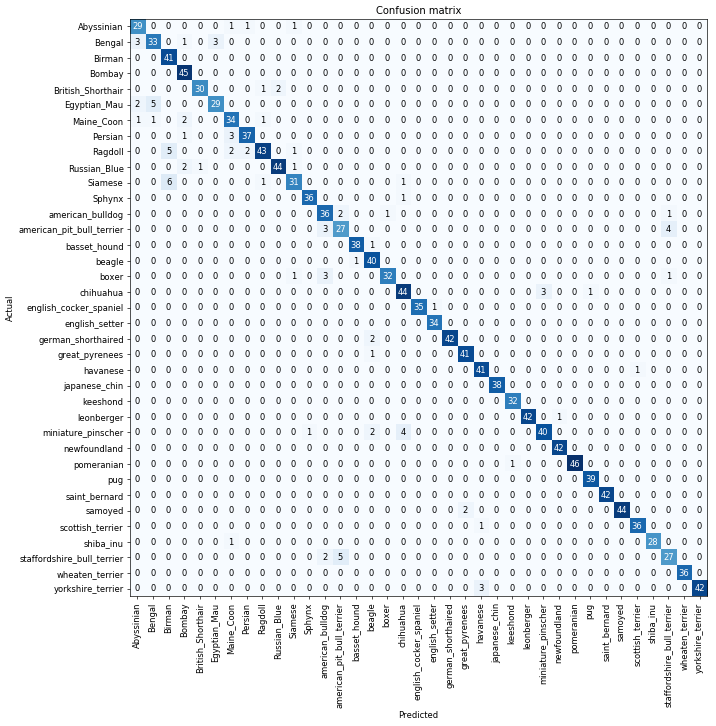

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # confusion matrix를 그려보자 (대각선이 정답을 맞춘 경우)

confusion matrix를 살펴보면 diagnol 이외의 위치에 큰 숫자가 적힌 case들을 볼 수 있다. 

즉, 해당 카테고리의 예측을 모델이 헷갈려하는 것이다.

most_confused 함수를 통해서 가장 많이 틀린 카테고리를 출력해보자.

In [0]:
interp.most_confused(min_val=2)

[('Siamese', 'Birman', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Ragdoll', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('miniature_pinscher', 'chihuahua', 4),
 ('Bengal', 'Abyssinian', 3),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Persian', 'Maine_Coon', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('boxer', 'american_bulldog', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Egyptian_Mau', 'Abyssinian', 2),
 ('Maine_Coon', 'Bombay', 2),
 ('Ragdoll', 'Maine_Coon', 2),
 ('Ragdoll', 'Persian', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('german_shorthaired', 'beagle', 2),
 ('miniature_pinscher', 'beagle', 2),
 ('samoyed', 'great_pyrenees', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

Siamese 를 Birman 로 6번 잘못 예측하였다.

## Unfreezing, fine-tuning, and learning rates

우리가 만든 모델이 잘 작동함을 알았으니, 이제 CNN 레이어들을 unfreeze 해서 fine tunning을 진행해 보자.

(resnet34는 34개의 layer를 가짐)

In [0]:
learn.unfreeze() # 그저 unfreeze 를 실행시키면 된다.

In [0]:
learn.fit_one_cycle(1) # 한사이클만 학습을 시켜보자

epoch,train_loss,valid_loss,error_rate,time
0,0.556216,0.343124,0.101489,01:53


위에서 freeze 한 상태로 학습했을 때보다 오히려 에러가 커졌다.

Why?

CNN의 모든 Layer 마다 각기 이미지의 각기 다른 특징을 추출해 내는데, 우리가 fine tunning을 하면서, 모든 레이어를 같은 Learning rate를 사용해서 학습했기 떄문에, 기존 Layer들이 엉뚱하게 학습되어 버린것. (또한 너무 큰 Learning rate) 즉, `미세하게 튜닝`되지 못했다. 

그러므로 각각의 layer마다 다른(+작은) Learning rate를 적용해 주어야 한다.

In [0]:
learn.load('stage-1') # 다시 이전에 freeze된 모델을 가져온다. 

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,saint_bernard,chihuahua,Birman,staffordshire_bull_terrier
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Maine_Coon,saint_bernard,yorkshire_terrier,pomeranian,pomeranian
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size

In [0]:
learn.lr_find() # 어떤 learning rate가 가장 좋을지 찾아주는 함수

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


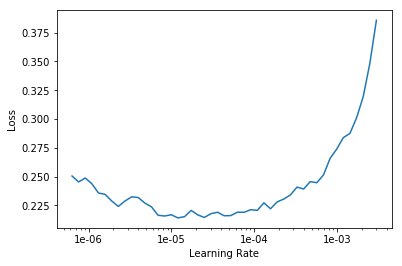

In [0]:
learn.recorder.plot()

Learning rate가 `1e-05~` 일때 가장 낮은 loss를 기록하는 것을 확인할수 있다. 

In [0]:
slice(1e-6,1e-4) # 1e-6 에서 시작해서 1e-4 까지 range

slice(1e-06, 0.0001, None)

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4)) # 기본 lr 은 0.003으로 설정되어 있으므로, max_lr 을 우리가 원하는 값으로 바꿔주자
# 이렇게 설정하면 앞쪽 Layer는 1e-6의 lr으로 시작하고, 뒤로 갈수록 lr이 증가해서 1e-4까지 증가하게 된다.

epoch,train_loss,valid_loss,error_rate,time
0,0.240295,0.198249,0.064276,01:53
1,0.213188,0.194239,0.060217,01:52


이렇게 freeze, unfreeze 두 단계를 거치면 충분히 좋은 모델을 만들 수 있다.

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 100653900.55it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


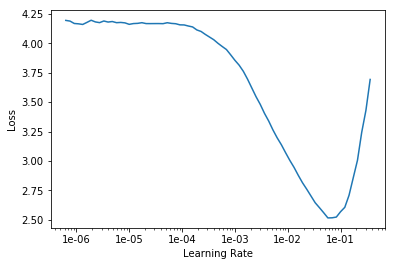

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.722925,0.280023,0.085927,03:32
1,0.407990,0.272099,0.088633,03:27
2,0.347223,0.289353,0.094046,03:26
3,0.281833,0.202405,0.069012,03:26
4,0.226387,0.196922,0.063599,03:26
5,0.141812,0.178004,0.056157,03:26
6,0.113651,0.178186,0.058187,03:25
7,0.108936,0.178131,0.056157,03:26


In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.106769,0.173961,0.055480,04:34
1,0.084419,0.163774,0.053451,04:29
2,0.071514,0.166109,0.054127,04:29


If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 7),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('basset_hound', 'beagle', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('Abyssinian', 'Russian_Blue', 3),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Ragdoll', 'Persian', 3),
 ('Siamese', 'Birman', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Birman', 'Ragdoll', 2),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 2),
 ('chihuahua', 'american_pit_bull_terrier', 2),
 ('english_cocker_spaniel', 'havanese', 2),
 ('leonberger', 'keeshond', 2),
 ('miniature_pinscher', 'chihuahua', 2)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

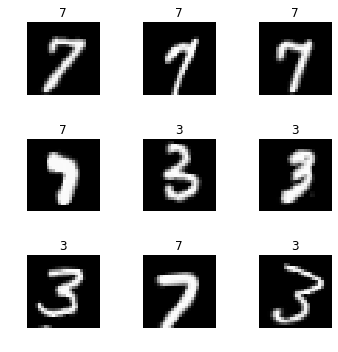

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 48144322.14it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.175200,0.090019,0.968597,00:26
1,0.103282,0.051685,0.978901,00:24


In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

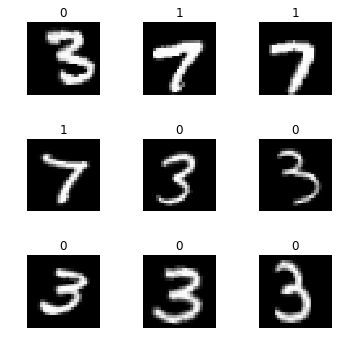

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']